### Инструкция
Выберите одно из окружение AI Gym - Classic Control (кроме CartPole) или Box2D - https://gym.openai.com/envs/

Изучите действия агента в заданной среде. Постройте алгоритм машинного обучения с подкреплением, который решает поставленную задачу после нужного количества обучающих эпизодов.

## Среда Mountain Car


### Описание
Mountain Car MDP - это детерминированный MDP, который состоит из автомобиля, размещенного стохастически на дне синусоидальной долины, с единственно возможными действиями - ускорениями которые могут быть применены к автомобилю в любом направлении. Целью МДП является стратегическое разгоняйте автомобиль, чтобы достичь заданного состояния на вершине правого холма. Существует две версии горной автомобильной области в гимназии: одна с дискретными действиями и одна с непрерывными. Эта версия имеет дискретные действия.

### Награда
Отрицательное вознаграждение -0.1 * действие2 получается на каждом шагу, чтобы наказать за принятие мер большого масштаба. Если горный автомобиль достигает цели, то положительное вознаграждение +100 добавляется к отрицательному вознаграждению за этот временной шаг.

### Конец эпизода
Эпизод заканчивается, если происходит одно из следующих событий:

Окончание: Положение автомобиля больше или равно 0,45 (положение цели на вершине правого холма)

Усечение: Длина эпизода составляет 999.

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer


### Загрузка среды

In [2]:
# env = gym.make('MountainCar-v0', render_mode='human')  # с рендеренгом
env = gym.make('MountainCar-v0')
env.reset()

(array([-0.53878576,  0.        ], dtype=float32), {})

### Изучения среды

In [5]:
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)
print("Количество шагов за которое нужно решить задачу:", env._max_episode_steps)

Пространство состояний: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Пространство действий: Discrete(3)
Количество шагов за которое нужно решить задачу: 200


### Дискретизация среды

Произведем дискретизацию состояний позиции и скорости машины.

In [125]:
print ("Нижняя граница", env.observation_space.low)
print ("Верхняя граница", env.observation_space.high)


Нижняя граница [-1.2  -0.07]
Верхняя граница [0.6  0.07]


In [110]:
n_bins = (10, 10)
def discretizer(position, velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([env.observation_space.low, env.observation_space.high])
    return tuple(map(int,est.transform([[position, velocity]])[0]))

In [111]:
print(discretizer(- 1.2, -0.07)) # проверка дискретитайзера 
print(discretizer(- 0.3, 0.01)) # проверка дискретитайзера 
print(discretizer(0.6, 0.07)) # проверка дискретитайзера 

(0, 0)
(5, 5)
(9, 9)


Создадим Q-таблицу из дискретных состояний среды и возможных действий

In [112]:
q_table = np.zeros(n_bins + (env.action_space.n,))
q_table.shape

(10, 10, 3)

### Политика агента
e-жадная стратегия и обновление таблицы


In [113]:
def policy (state, env, eps):
    if np.random.random() < eps: 
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(q_table[state])
    return action

def policy_update (current_state, new_state, reward, action, lr):
    q_table[current_state][action] = (1-lr)*q_table[current_state][action] + lr*(reward + np.max(q_table[new_state]))

### Тестирование стратегии
Проведем обучение и построим график минимального количество шагов до достижения цели.
* Возьмем eps = 0.1 и будем медленно уменьшать его.
* Ограничим число попыток на каждом эпизоде равное env._max_episode_steps (200).
* Будем увеличивать отрицательную награду на 1 когда количество эпизодов будет более 900, а количество попыток в каждом будет больше 150.

In [114]:
progress = []  
avg_progress = []
eps = 0.1
lr = 0.8
n_episodes = 3000
for e in range(n_episodes):
    if e % 1000 == 0:
        print(e, 'eps', eps, 'lr', lr)
    _ = 0
    current_state, done = discretizer(*env.reset()[0]), False
    reward_q_t = 0
    while done==False:
        _ += 1
        action = policy(current_state, env, eps)
        obs, reward, done, trunc, info = env.step(action)
        # print(action, reward)
        new_state = discretizer(*obs)
        # Отрицательное вознаграждение -0.1 * действие2 получается на каждом шагу, чтобы наказать за принятие мер большого масштаба.
        # Выяснилось, что всегда дается -1.0, по этому напишем свою логику вручения наград
        if e > 900:
            if _ > 149:  # попробуем побудить агента совершать как можно меньше действий достигая макс. результата на уже отобранных хороших вариантах
                reward_q_t -=1
        reward_q_t += 0.2*reward
        reward = round(reward_q_t)
        # Если горный автомобиль достигает цели, то положительное вознаграждение +100 добавляется к отрицательному вознаграждению за этот временной шаг.
        if done==True:
            # reward += (300 - _)
            reward += 100
        if _ == env._max_episode_steps:
            reward *= 2
        policy_update(current_state, new_state, reward, action, lr)
        current_state = new_state
        lr *= 0.99995
        eps *= 0.99995
        if _ == env._max_episode_steps:
            break
#        env.render()
    progress.append(_)
    avg_progress.append(np.mean(progress))

0 eps 0.1 lr 0.8


c:\Users\Alex-pc-R\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1000 eps 2.3039636769512045e-05 lr 0.00018431709415609636
2000 eps 1.1889814576464486e-08 lr 9.511851661171589e-08


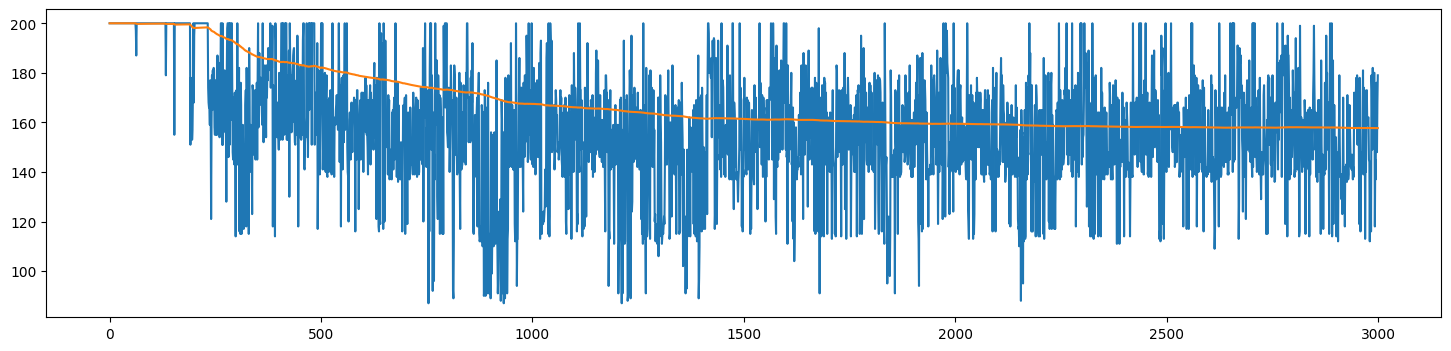

In [115]:
plt.figure(figsize=(18, 4))
plt.plot(progress)
plt.plot(avg_progress)
plt.show()

Проведем 1000 попыток и вычислим среднее минимальное количество действий для достижения результата.

In [119]:
mean_act = []
for i in range(1000):
    eps = 0
    _ = 0
    current_state, done = discretizer(*env.reset()[0]), False
    while done==False:
        _ += 1
        action = policy(current_state, env, eps)
        obs, reward, done, trunc, info = env.step(action)
        new_state = discretizer(*obs)
        current_state = new_state
        # env.render()
        # time.sleep(0.05)
    mean_act.append(_)
# env.close()


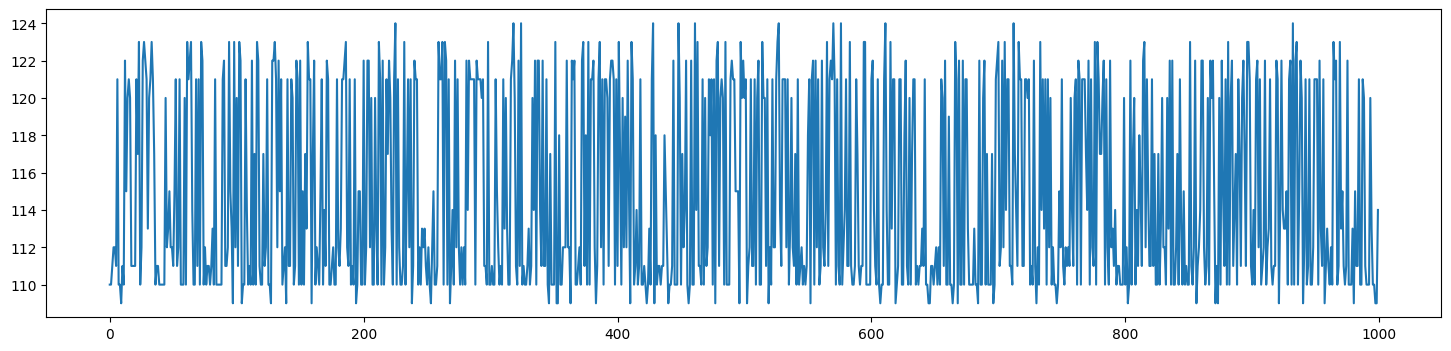

Среднее количество действий до достижения резальтата: 114.852


In [121]:
plt.figure(figsize=(18, 4))
plt.plot(mean_act)
plt.show()
print("Среднее количество действий до достижения результата:", np.mean(mean_act))

### Среднее количество действий составило 115, оно очень зависит от обучения агента, иногда обучение впадает в ступор и результат выходит более 200. 